# Table of contents
- [Description of the problem and algorithms](##Description-of-the-problem-and-algorithms)
- [Assembling datasets](##Assembling-datasets)
- [Fitting regression](##Fitting-regression)
- [Faster assembling and extracting more features](##Faster-assembling-and-extracting-more-features)
- [Regression with more features](##Regression-with-more-features)


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier

## Description of the problem and algorithms

**Problem**: multiclass classifier and extracting features from limit order book, bbos and trade flows. 

Firstly, three metrics were calculated using (Jakob Albers, 2021) approach: order imbalance (IMB), trade imbalance and past returns. Two last indexes were also computed for spot market in order to extract cross-market information. 

Secondly, these metrics were combined to one dataset which was later used for fitting regression. One can notice that classes are imbalanced: there are approximately $82%$ instances of $0$ class (no price movement). Therefore, Catboot classifier will perfrom much better than just logistic regression. 

**Results**: Catboost classifier has $0.8295$ accuracy score and logistic regression - $0.8217$ which is better than always predicting 0 class. Catboost has better confusion matrix: $0$ is predicted instead of $-1$ and $1$ less frequently than in logistic classifier.

**Important note**: if one can modify algorithm of concatenating arrays and processing larger datasets, catboost is likely to give $>90\%$ accuracy. To prove that one can upload zero regression_set (120k rows) and try to fit catboost classifier. 

In [2]:
def concatenate_datasets(book, ticker):
    '''
    Function performs conctenating book and ticker dataframes:
    for each row in ticker concatenate the most recent observation from order book.
    In case there is no appropriate row we take the first one (it is for future modifications).
    '''

    ticker['local_time'] = pd.to_datetime(ticker['local_ts'])
    book['local_time'] = pd.to_datetime(book['local_timestamp'])
    book.sort_values(by = 'local_time', inplace = True)
    ticker.sort_values(by = 'local_time', inplace = True)
    
    # creating arrays for concatenating only these columns
    bids_prices = [f'bids[{i}].price' for i in range(1,25)]
    bids_amount = [f'bids[{i}].amount' for i in range(1,25)]
    asks_prices = [f'asks[{i}].price' for i in range(1,25)]
    asks_amount = [f'asks[{i}].amount' for i in range(1,25)]

    index1 = book.index.min() # starting index of book
    for index2, row2 in tqdm(ticker.iterrows()): # iterate through each row in ticker
        try:
            while book.loc[index1, 'local_time'] < row2['local_time']:
                index1 += 1
        except KeyError:
            pass
        if (index1 == book.index.min()) & (book.loc[index1, 'local_time'] >= row2['local_time']):
            pass
        else: index1 -= 1 # otherwise index1 containts index where time in order book higher that in ticker
        ticker.loc[index2, bids_prices] = book.loc[index1, bids_prices]
        ticker.loc[index2, bids_amount] = book.loc[index1, bids_amount]
        ticker.loc[index2, asks_prices] = book.loc[index1, asks_prices]
        ticker.loc[index2, asks_amount] = book.loc[index1, asks_amount]
    
    # renaming the first level just for convinience in future code
    ticker.rename({'bid_price': 'bids[0].price', 'ask_price': 'asks[0].price', \
                   'bid_amount': 'bids[0].amount', 'ask_amount':'asks[0].amount'}, \
                 axis = 1, inplace = True)

def IMB(book_snap, side = 'a'):
    '''
    Calculates order imbalance either for asks ('a') or bid side ('b')
    '''
    
    # as proposed in the article, we take median amount of 5 best levels in book 
    ask_levels = [f'asks[{i}].amount' for i in range(5)]
    bid_levels = [f'bids[{i}].amount' for i in range(5)]
    i = 0
    p_n = 0
    if side == 'a':
        N = np.median(book_snap[ask_levels].to_numpy())
        
        # trying to sell all assets N for best price in book
        while N - book_snap[f'asks[{i}].amount'] > 0:
            p_n += book_snap[f'asks[{i}].amount'] * book_snap[f'asks[{i}].price']
            N -= book_snap[f'asks[{i}].amount']
            i += 1
        
        
        p_n += N * book_snap[f'asks[{i}].price']
        p_n /= np.median(book_snap[ask_levels].to_numpy())
        p_0 = book_snap['asks[0].price']
        
        return (p_n/p_0 - 1) * 10000
    else:
        N = np.median(book_snap[bid_levels].to_numpy())
        
        while N - book_snap[f'bids[{i}].amount'] > 0:
            p_n += book_snap[f'bids[{i}].amount'] * book_snap[f'bids[{i}].price']
            N -= book_snap[f'bids[{i}].amount']
            i += 1
        
        
        p_n += N * book_snap[f'bids[{i}].price']
        p_n /= np.median(book_snap[bid_levels].to_numpy())
        p_0 = book_snap['bids[0].price']
        
        return (p_0/p_n - 1) * 10000

def trade_imb(trades, ticker):
    '''
    Computes trade imbalance as buy_flow - sell_flow in 150 ms interval
    '''
    interval = pd.Timedelta('00:00:00.150')
    trades['local_time'] = pd.to_datetime(trades['local_ts'])

    for index, row in tqdm(ticker.iterrows()):
        current_time = row['local_time']
        
        grouped_trades = trades[(trades['local_time'] <= current_time) & \
                           (trades['local_time']>= current_time- interval)][['side', 'amount']] \
                        .groupby('side').sum() # grouping array for appealing to particilar side 
        if 'S' in grouped_trades.index: 
            sell_flow = grouped_trades.loc['S', 'amount']
        else: sell_flow = 0

        if 'B' in grouped_trades.index:
            buy_flow = grouped_trades.loc['B', 'amount']
        else: buy_flow = 0

        ticker.loc[index, 'trade_imb'] = buy_flow - sell_flow
        del grouped_trades, sell_flow, buy_flow

def past_returns(trades, ticker):
    interval = pd.Timedelta('00:00:00.150')
    delta = pd.Timedelta('00:00:00.050')

    for index, row in tqdm(ticker.iterrows()):
        # checking all appropriate prices and amount in trades in previous time interval
        current_time = row['local_time'] - interval
        grouped_trades = trades[(trades['local_time'] <= current_time) & \
                           (trades['local_time']>= current_time- delta)][['price', 'amount']]

        # weight prices according to their amount
        grouped_trades['weighted_price'] = grouped_trades['amount'] * grouped_trades['price']
        if grouped_trades['amount'].sum() == 0:
            ticker.loc[index, 'past_returns'] = np.nan # we do not have any observations, let's fill it later
            continue
        p_t = grouped_trades['weighted_price'].sum() / grouped_trades['amount'].sum()

        # checking all appropriate prices and amount in trades in current time interval
        current_time = row['local_time']
        grouped_trades = trades[(trades['local_time'] <= current_time) & \
                           (trades['local_time']>= current_time- delta)][['price', 'amount']]

        # again weight them
        grouped_trades['weighted_price'] = grouped_trades['amount'] * grouped_trades['price']
        if grouped_trades['amount'].sum() == 0:
            ticker.loc[index, 'past_returns'] = np.nan # we do not have any observations, let's fill it later
            continue
        p_d = grouped_trades['weighted_price'].sum() / grouped_trades['amount'].sum()

        ticker.loc[index, 'past_returns'] = (p_t/p_d - 1)* 10000

        del grouped_trades, p_t, p_d

    # for first observations we do not have information about past trades, so we should fill nans 
    ticker['past_returns'].fillna(ticker['past_returns'].mean(), inplace = True)

## Assembling datasets

Ticker and book are large datasets containing 37m and 6m rows respectively. That's why we should operate them by chunks. Than datasets are processed all metrics are recorded in `regressio_set{n}` dataframe and converted to csv file.  

The first regression_set contains 120k observations and all others - by 12k, such small size cause `NaN` values in past_returns and, hence, decrease performance of classifier (there is a trade-off between safety of computing and size of processed dataset). Due to time and computational limits only 33 sets were retrieved. 

Than, all regression sets iteratively were read and concatenated to huge dataset `regression_features`.  

In [15]:
book = pd.read_csv(r'data\book.csv', nrows = 100)
book.loc[:5, 'asks[0].price']

0    28091.2
1    28090.9
2    28090.9
3    28090.9
4    28090.9
5    28090.9
Name: asks[0].price, dtype: float64

In [24]:
from IPython.display import clear_output

ticker = pd.read_csv(r'data\ticker.csv', chunksize = 12*10**3, skiprows = range(1,12*10**4+12*10**3), header = 0)
book = pd.read_csv(r'data\book.csv', chunksize = 2*10**3, skiprows = range(1,2*10**4+2*10**3), header = 0)
trades = pd.read_csv(r'data\trades.csv', chunksize = 4*10**3, skiprows = range(1,4*10**4+4*10**3), header = 0)
trades_spot = pd.read_csv(r'data\trades.spot.csv', chunksize = 2*10**3, skiprows = range(1,2*10**4+2*10**3), header = 0)

n = 1
for ticker_chunk, book_chunk, trades_chunk, trades_spot_chunk in zip(ticker, book, trades, trades_spot):
    df_regression = pd.DataFrame() # dataframe for all features
    
    # concatenating main datasets and calculating order imbalanace
    concatenate_datasets(book_chunk, ticker_chunk)
    ticker_chunk['IMB_a'] = ticker_chunk.apply(IMB, side = 'a', axis = 1)
    ticker_chunk['IMB_b'] = ticker_chunk.apply(IMB, side = 'b', axis = 1)
    df_regression['IMB'] = ticker_chunk['IMB_a'] - ticker_chunk['IMB_b']
    df_regression['local_ts'] = ticker_chunk['local_ts']
    del book_chunk
    
    # trading imbalance and past returns for perp contracts
    trade_imb(trades_chunk, ticker_chunk)
    past_returns(trades_chunk, ticker_chunk)
    del trades_chunk
    df_regression['trade_imb'] = ticker_chunk['trade_imb']
    df_regression['past_returns'] = ticker_chunk['past_returns']
    
    # trading imbalance and past returns for spot contracts
    trade_imb(trades_spot_chunk, ticker_chunk)
    past_returns(trades_spot_chunk, ticker_chunk)
    df_regression['trade_imb_spot'] = ticker_chunk['trade_imb']
    df_regression['past_returns_spot'] = ticker_chunk['past_returns']
    
    # log returns
    mid_price = (ticker_chunk.['asks[0].price'] + ticker_chunk.['bids[0].price'])/2
    df_regression['log_returns'] = np.log(mid_price) - np.log(mid_price.shift(1))
    df_regression['log_returns'].fillna(df_regression['log_returns'].mean(), inplace = True)
    
    # autocorrelation feature
    for i in tqdm(range(ticker_chunk.shape[0])):
        df_regression.loc[i, 'autcorr'] = mid_price[:i+1].autocorr(lag = 1)
        df_regression['autocorr'].fillna(df_regression['autocorr'].mean, inplace = True)
    
    # Realized variance
        df_regression['realized_variance'] = (df_regression.loc[:i, 'log_returns']**2).sum()
   

    del ticker_chunk
    
    
    
    # saving regression batch 
    df_regression.to_csv(f'data\\regression_set{n}.csv')
    del df_regression
    
    n += 1
    clear_output()

12000it [04:37, 43.26it/s]
12000it [00:43, 278.98it/s]
12000it [00:37, 318.05it/s]
12000it [00:44, 267.79it/s]
12000it [00:36, 329.52it/s]
12000it [04:22, 45.71it/s]
12000it [00:44, 271.84it/s]
12000it [00:39, 301.22it/s]
12000it [00:40, 293.68it/s]
12000it [00:32, 364.43it/s]
12000it [04:26, 45.05it/s]
12000it [00:43, 278.97it/s]
12000it [00:36, 328.28it/s]
12000it [00:38, 310.98it/s]
12000it [00:36, 329.30it/s]
12000it [04:13, 47.31it/s]
12000it [00:46, 258.80it/s]
12000it [00:35, 342.06it/s]
12000it [00:42, 280.70it/s]
12000it [00:30, 387.38it/s]
12000it [04:18, 46.50it/s]
12000it [01:00, 199.98it/s]
12000it [00:50, 236.52it/s]
12000it [00:42, 279.08it/s]
12000it [00:41, 289.72it/s]
12000it [04:12, 47.45it/s]
12000it [00:45, 263.92it/s]
12000it [00:35, 338.70it/s]
12000it [00:42, 282.86it/s]
12000it [00:33, 358.82it/s]
12000it [03:38, 54.86it/s]
12000it [00:36, 330.37it/s]
12000it [00:33, 355.97it/s]
12000it [00:36, 330.29it/s]
12000it [00:30, 390.09it/s]
12000it [03:33, 56.19it/s]


KeyboardInterrupt: 

In [26]:
# concatenating all sets to one huge dataset
features = pd.DataFrame()
for n in range(0,34):
    features_n = pd.read_csv(f'data\\regression_set{n}.csv').drop(['Unnamed: 0', 'local_ts'], axis = 1)
    features = pd.concat((features, features_n), ignore_index = True, axis = 0)
    del features_n

features.to_csv(r'data\regression_features.csv')

## Fitting regression

Experiments showed that for sklearn logistic regression best solver is `'lfgs'` with no penalty and class weights `{-1:0.4, 0:0.2, 1:0.4}` to cope with the imbalance of classes. 

Nonetheless, Catboost still performs better :)

In [3]:
# they are already sorted, so no preprocessing is needed
features = pd.read_csv(r'data\regression_features.csv').drop(['Unnamed: 0'], axis = 1)
target = pd.read_csv(r'data\target1 .csv', nrows = features.shape[0])['clf_target1']

features['past_returns_spot'].fillna(features['past_returns_spot'].mean(), inplace = True)
features['past_returns'].fillna(features['past_returns'].mean(), inplace = True)

In [4]:
# with baseline approach we can just predict 0 class because of imbalance
target.value_counts()[0] / target.count() # it's baseline score that we want to outperfrom

0.8208914728682171

Accuracy is 0.8210852713178295
ROC-AUC score is 0.508210810933167


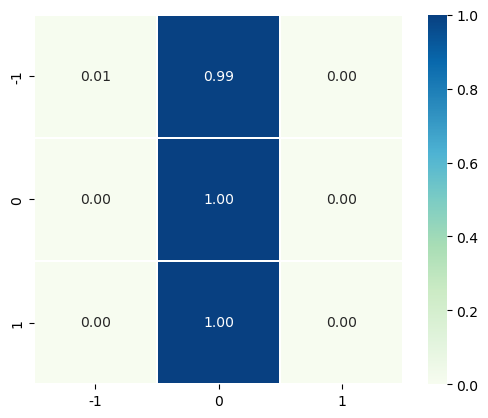

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

regressor = LogisticRegression(class_weight = {-1:0.4, 0:0.2, 1:0.4}, max_iter = 10**5, random_state = 0, penalty = None, solver = 'lbfgs')
regressor.fit(x_train, y_train)

preds = regressor.predict(x_test)
preds2 = regressor.predict_proba(x_test)
print(f'Accuracy is {accuracy_score(preds, y_test)}')
print(f'ROC-AUC score is {roc_auc_score(y_test, preds2, multi_class = "ovr")}')
cm = confusion_matrix(y_test, preds, normalize='true')
cm = confusion_matrix(y_test, preds, normalize='true')
sns.heatmap(cm, annot = True, fmt='.2f', linewidth=0.1, \
            square=True, xticklabels = [-1,0,1], yticklabels = [-1,0,1], cmap='GnBu');

Accuracy is 0.8327228682170542
ROC-AUC score is 0.6904951025468237


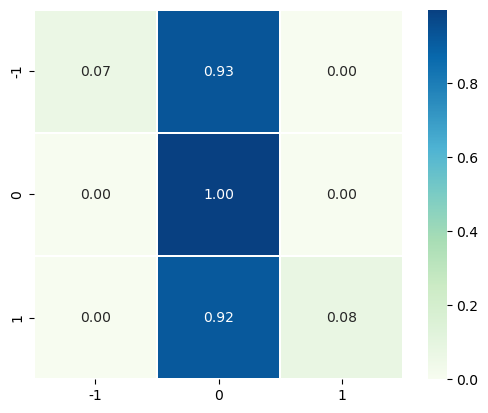

In [14]:
regressor = CatBoostClassifier(silent = True)
regressor.fit(x_train, y_train)

preds = regressor.predict(x_test)
preds2 = regressor.predict_proba(x_test)
print(f'Accuracy is {accuracy_score(preds, y_test)}')
print(f'ROC-AUC score is {roc_auc_score(y_test, preds2, multi_class = "ovr")}')
cm = confusion_matrix(y_test, preds, normalize='true')
sns.heatmap(cm, annot = True, fmt='.2f', linewidth=0.1, \
            square=True, xticklabels = [-1,0,1], yticklabels = [-1,0,1], cmap='GnBu');

## Faster assembling and extracting more features

Another method of assembing uses `pd.merge_asof()` function instead of iterating through each row comparing locat time. It's much faster but has an essential problem with huge datasets: working with chunks gives a huge amount of `nan` values in distant chunks (because number of observation in book becomes less with increasing a number of chunk). Hence, more efficient algorithm is required to properly extract features without loss of information.

New features were calculated using (Ntakaris A., Kanniainen J., 2019) and (Ntakaris A., Mirone G., 2019). Among them are:
- log returns
- autocorrelation with lag = 1
- realised variance
- realised bipower variance
- jump variation
- weighted mean price
- bid-ask spread
- normalized bid-ask spread

In [3]:
n = 15
ticker = pd.read_csv(r'data\ticker.csv', skiprows = range(1, n*12*10**4), chunksize = 12*10**4, header = 0)
book = pd.read_csv(r'data\book.csv', skiprows = range(1, n*2*10**4), chunksize = 2*10**4, header = 0)
trades = pd.read_csv(r'data\trades.csv', skiprows = range(1, n*4*10**4), chunksize = 4*10**4, header = 0)
trades_spot = pd.read_csv(r'data\trades.spot.csv', skiprows = range(1, n*2*10**4), chunksize = 2*10**4, header = 0)

n = 13
for ticker_chunk, book_chunk, trades_chunk, trades_spot_chunk in zip(ticker, book, trades, trades_spot):
    df_regression = pd.DataFrame() # dataframe for all features
    
    # freeing up memory
    ticker_chunk.drop(['seq', 'remote_ts', 'remote_ts2'], axis = 1,  inplace = True)
    book_chunk.drop(['exchange', 'symbol', 'timestamp'], axis = 1, inplace = True)
    
    # concatenating main datasets
    ticker_chunk.sort_values(by = 'local_ts', inplace = True)
    book_chunk.sort_values(by = 'local_timestamp', inplace = True)
    ticker_chunk = pd.merge_asof(ticker_chunk, book_chunk, left_on = 'local_ts', right_on = 'local_timestamp')
    ticker_chunk.drop(['bids[0].price', 'bids[0].amount', 'asks[0].price', 'asks[0].amount'], axis = 1, inplace = True)
    ticker_chunk.rename({'bid_price': 'bids[0].price', \
                        'bid_amount': 'bids[0].amount', \
                        'ask_price': 'asks[0].price', \
                        'ask_amount': 'asks[0].amount'}, axis = 1, inplace = True) # renaming to ensure compatibility
    ticker_chunk['local_time'] = pd.to_datetime(ticker_chunk['local_ts'])
    
    
    # order imbalance
    ticker_chunk['IMB_a'] = ticker_chunk.apply(IMB, side = 'a', axis = 1)
    ticker_chunk['IMB_b'] = ticker_chunk.apply(IMB, side = 'b', axis = 1)
    df_regression['IMB'] = ticker_chunk['IMB_a'] - ticker_chunk['IMB_b']
    df_regression['local_ts'] = ticker_chunk['local_ts']
    del book_chunk
    
    # trading imbalance and past returns for perp contracts
    trade_imb(trades_chunk, ticker_chunk)
    past_returns(trades_chunk, ticker_chunk)
    del trades_chunk
    df_regression['trade_imb'] = ticker_chunk['trade_imb']
    df_regression['past_returns'] = ticker_chunk['past_returns']
    
    # trading imbalance and past returns for spot contracts
    trade_imb(trades_spot_chunk, ticker_chunk)
    past_returns(trades_spot_chunk, ticker_chunk)
    df_regression['trade_imb_spot'] = ticker_chunk['trade_imb']
    df_regression['past_returns_spot'] = ticker_chunk['past_returns']
    
    # log returns
    mid_price = (ticker_chunk['asks[0].price'] + ticker_chunk['bids[0].price'])/2
    df_regression['log_returns'] = np.log(mid_price) - np.log(mid_price.shift(1))
    df_regression['log_returns'].fillna(df_regression['log_returns'].mean(), inplace = True)
    
    # autocorrelation feature
    for i in range(2, ticker_chunk.shape[0]):
        df_regression.loc[i, 'autocorr'] = mid_price[:i+1].autocorr(lag = 1)
        
    
        # Realized variance
        df_regression.loc[i, 'realized_variance'] = (df_regression.loc[:i, 'log_returns']**2).sum()
   
        # Realized bipower variance
        df_regression.loc[i, 'bipower_variance'] = (np.abs(df_regression.loc[:i,'log_returns']) * np.abs(df_regression.loc[:i, 'log_returns'].shift(-1))).sum()
    
    # Jump variation
    df_regression['jump_variation'] = df_regression['realized_variance'] - df_regression['bipower_variance']
    df_regression['jump_variation'][df_regression['jump_variation'] < 0] = 0
    
    # weighted mean price
    df_regression['weighted_mean_price'] = (ticker_chunk['asks[0].price']*ticker_chunk['asks[0].amount'] \
                                            + ticker_chunk['bids[0].amount']*ticker_chunk['bids[0].price']) \
                                            / (ticker_chunk['bids[0].amount']+ticker_chunk['asks[0].amount'])
    
    
    # bid-ask spread
    df_regression['bid_ask_spread'] = ticker_chunk['asks[0].amount'] - ticker_chunk['bids[0].amount']
    
    # normalized bid-ask spread (with tick_size = 0.1)
    tick_size = 0.1
    df_regression['norm_spread'] = df_regression['bid_ask_spread'] / tick_size
    
    
    del ticker_chunk
    
    # saving regression batch 
    df_regression.to_csv(f'D:\\Python_projects\\hft_project\\regression_set{n}.csv')
    del df_regression
    
    n += 1
    print(f'{n} datasets are completed!')

120000it [05:15, 380.79it/s]
120000it [04:44, 422.32it/s]
120000it [04:59, 400.36it/s]
120000it [04:21, 458.56it/s]
C:\Users\Никита\AppData\Local\Temp\ipykernel_5036\3386054393.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['jump_variation'][df_regression['jump_variation'] < 0] = 0


14 datasets are completed!


120000it [04:47, 417.89it/s]
120000it [04:05, 489.57it/s]
120000it [04:34, 437.76it/s]
120000it [03:54, 511.89it/s]
C:\Users\Никита\AppData\Local\Temp\ipykernel_5036\3386054393.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['jump_variation'][df_regression['jump_variation'] < 0] = 0


15 datasets are completed!


KeyboardInterrupt: 

## Regression with more features

This section is dedicated to obtaining regressions for datasets with new features. Firstly, it will be shown that essential part of information is lost due to unefficient concatenation. Secondly, feature importance techniques will be applied. 

From individual waterfall plots for each class one can notice *different impact of features to classes*. Especially it's true for the third class ($+1$) where autocorrelation was outstripped by bipower variance. 

As aggregated barplot shows, *weighted mean price, autocorrelation and variances* are the most valuable features in the dataset.

Not surprisingly, **adding such impactful features gives better results and $0.99$ accuracy and ROC-AUC score**. 

In [2]:
df_1 = pd.read_csv('data\\regression_set0.csv')
target = pd.read_csv('data\\target1 .csv', nrows = 12*10**4)['clf_target1']
print(df_1.isna().sum()) # as we see, there are a little number of nans, we can fill them with mean values

for column in ['IMB', 'autocorr', 'realized_variance', 'bipower_variance', 'jump_variation']:
    df_1[f'{column}'].fillna(df_1[f'{column}'].mean(), inplace = True)

df_1.drop(['Unnamed: 0', 'local_ts'], axis = 1, inplace = True)

Unnamed: 0              0
IMB                    27
local_ts                0
trade_imb               0
past_returns            0
trade_imb_spot          0
past_returns_spot       0
log_returns             0
autocorr               11
realized_variance       2
bipower_variance        2
jump_variation          2
weighted_mean_price     0
bid_ask_spread          0
norm_spread             0
dtype: int64


In [17]:
# for instance let's choose 3-rd piece of regression dataset
df_2 = pd.read_csv('data\\regression_set3.csv')
df_2.isna().sum() # we see 40% nans in IMB and totally missed past_returns_spot column
# In consequence, only first volume of dataset will be used to demonstrate feature importance

Unnamed: 0                  0
IMB                     70971
local_ts                    0
trade_imb                   0
past_returns                0
trade_imb_spot              0
past_returns_spot      120000
log_returns                 0
autocorr                   40
realized_variance           2
bipower_variance            2
jump_variation              2
weighted_mean_price         0
bid_ask_spread              0
norm_spread                 0
dtype: int64

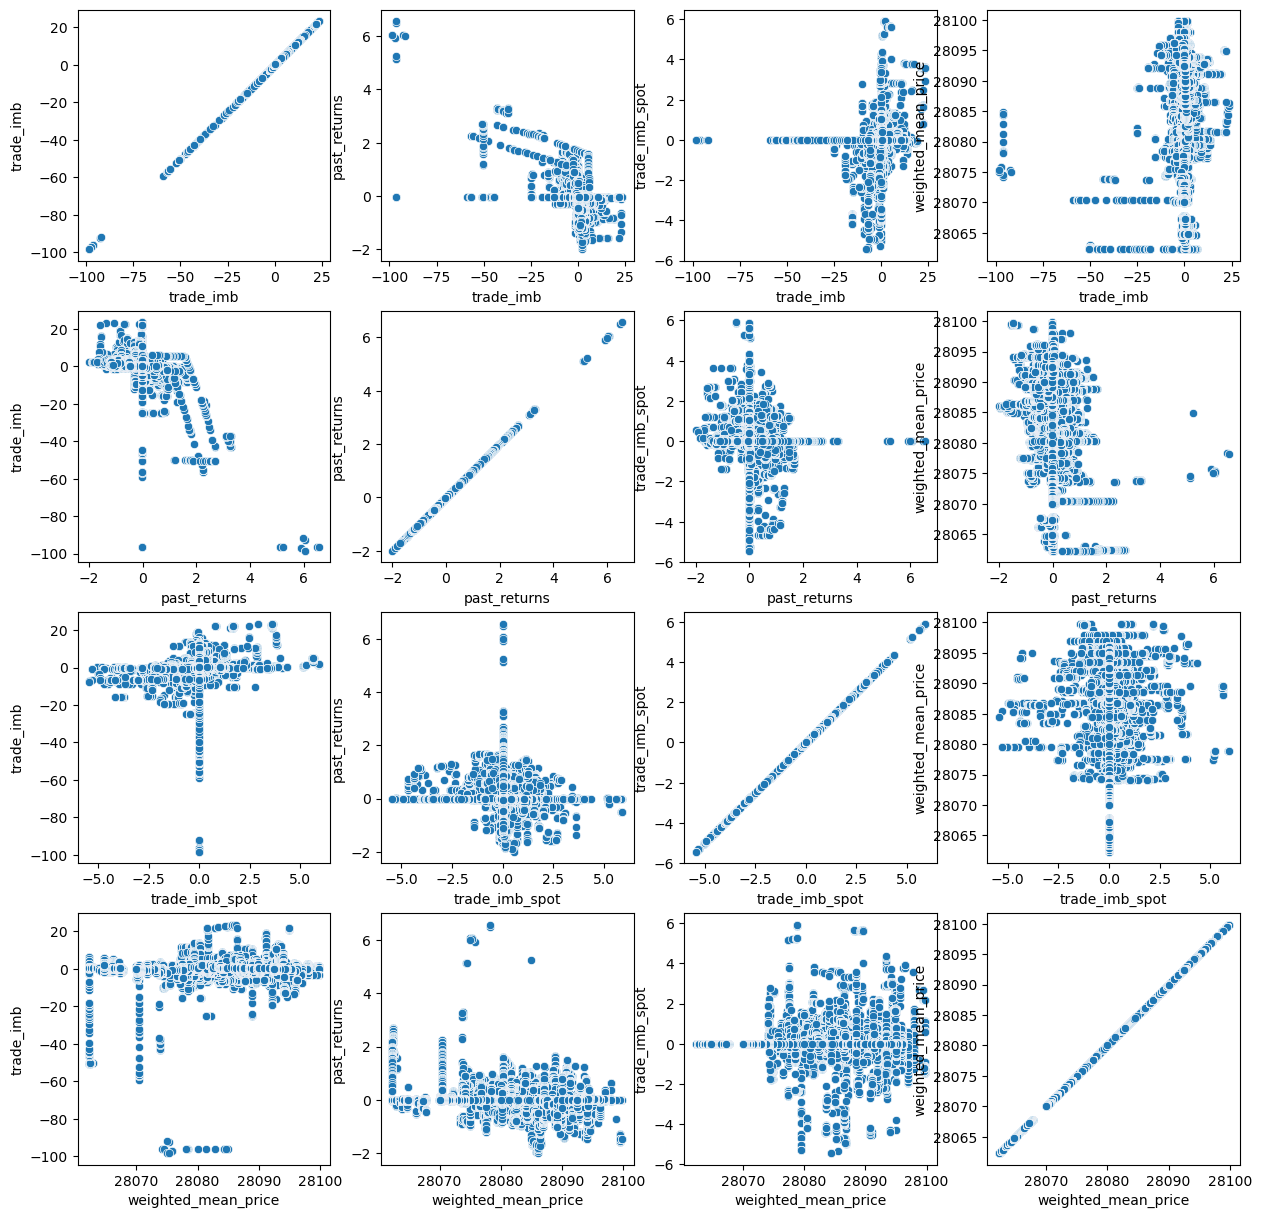

In [19]:
# let's draw a correlation plots between some non-linear dependent features

features = ['trade_imb', 'past_returns', 'trade_imb_spot', \
           'weighted_mean_price']

fig, ax = plt.subplots(len(features), len(features), figsize = (15,15))

for i in range(len(features)):
    for j in range(len(features)):
        sns.scatterplot(data = df_1, x = features[i], y = features[j], ax = ax[i][j])
        
plt.savefig('Correlation plot.png', dpi = 300)

In [3]:
# shap values will be used to estimate feature's contribution to a model
import shap

x_train, x_test, y_train, y_test = train_test_split(df_1, target.to_numpy().ravel(), test_size = 0.2)

regressor = CatBoostClassifier(silent = True).fit(x_train, y_train)
predictions = regressor.predict(x_train)

explainer = shap.Explainer(regressor)
shap_values = explainer(x_train)

D:\conda\envs\new_env\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
D:\conda\envs\new_env\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


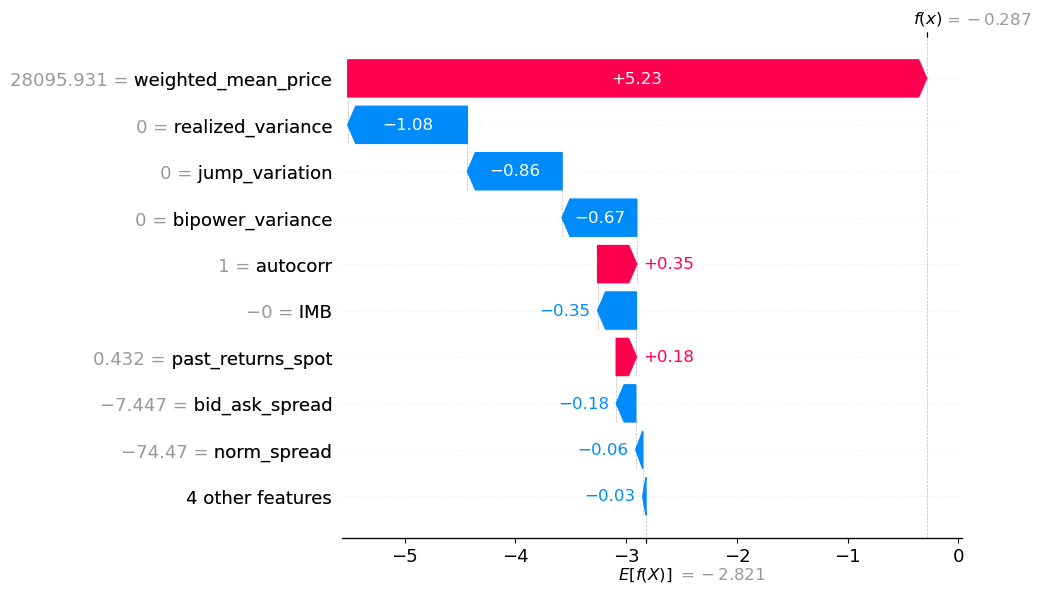

In [4]:
shap.plots.waterfall(shap_values[0,:,0])

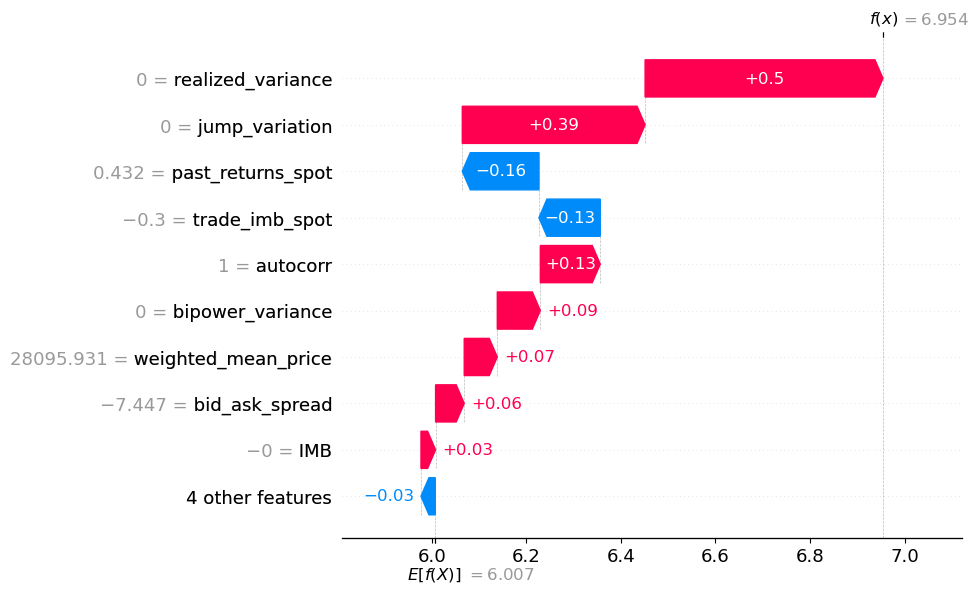

In [5]:
shap.plots.waterfall(shap_values[0,:,1])

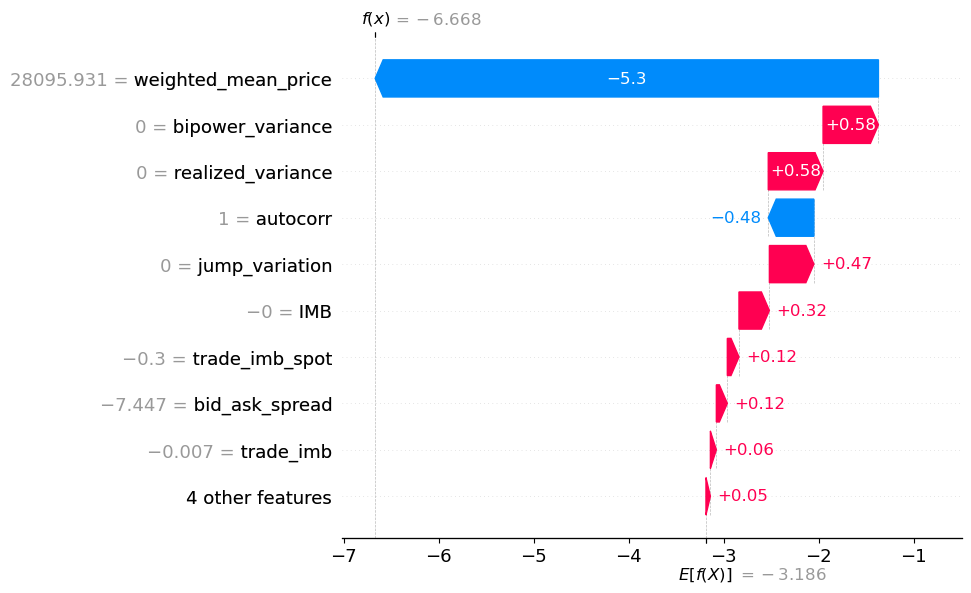

In [6]:
shap.plots.waterfall(shap_values[0,:,2])

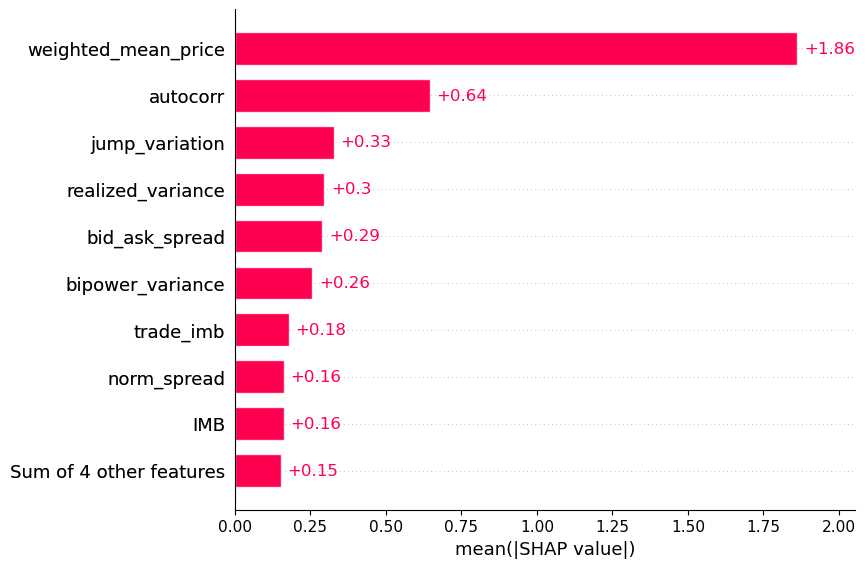

In [8]:
new_shap_values = []
for i, pred in enumerate(predictions.ravel()):
    # get shap values for predicted class
    new_shap_values.append(shap_values.values[i][:,pred])
    
shap_values.values = np.array(new_shap_values)

shap.plots.bar(shap_values, show = False) # mean impact for each class
plt.savefig('Featute importance.png')

Accuracy is 0.9990833333333333
ROC-AUC score is 0.9999885898379667


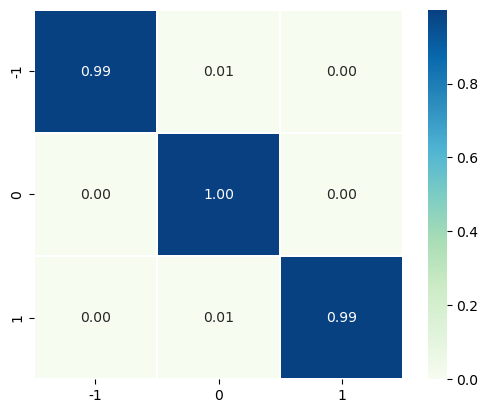

In [72]:
# let's test accuracy and plot confusion matrix for new_features

preds = regressor.predict(x_test)
preds2 = regressor.predict_proba(x_test)
print(f'Accuracy is {accuracy_score(preds, y_test)}')
print(f'ROC-AUC score is {roc_auc_score(y_test, preds2, multi_class = "ovr")}')
cm = confusion_matrix(y_test, preds, normalize='true')
cm = confusion_matrix(y_test, preds, normalize='true')
sns.heatmap(cm, annot = True, fmt='.2f', linewidth=0.1, \
            square=True, xticklabels = [-1,0,1], yticklabels = [-1,0,1], cmap='GnBu');